# Import Librariies

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import plot_model

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


from PIL import Image


import os
import random


import warnings
warnings.filterwarnings("ignore")

# Get Data

In [41]:
image_folder_path = '/kaggle/input/teeth-dataset/Teeth_Dataset'
train_path = '/kaggle/input/teeth-dataset/Teeth_Dataset/Training'
test_path = '/kaggle/input/teeth-dataset/Teeth_Dataset/Testing'
validation_path = '/kaggle/input/teeth-dataset/Teeth_Dataset/Validation'

In [42]:
folders = list(os.listdir(image_folder_path))
print(folders)

['Validation', 'Training', 'Testing']


In [43]:
train_data = tf.keras.utils.image_dataset_from_directory(train_path)
test_data = tf.keras.utils.image_dataset_from_directory(test_path)
validation_data = tf.keras.utils.image_dataset_from_directory(validation_path)

Found 3087 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.
Found 1028 files belonging to 7 classes.


In [44]:
diseases = list(os.listdir(os.path.join(image_folder_path,'Testing')))
print(diseases)

['OC', 'CaS', 'OT', 'CoS', 'Gum', 'MC', 'OLP']


# Prepare Data

In [45]:
def plot_1_per_disease_in_folder(folder):
    fig, axes = plt.subplots(1, len(diseases), figsize=(10, 10))

    for ax, disease in zip(axes, diseases):
        diseases_dir = os.path.join(image_folder_path, folder, disease)
        valid_extensions = ('.jpeg', '.jpg', '.bmp', '.png')
        diseases_images = list(filter(lambda x: x.endswith(valid_extensions), os.listdir(diseases_dir)))

        if diseases_images:
            img_path = os.path.join(diseases_dir, random.choice(diseases_images))
            image = plt.imread(img_path)
            ax.imshow(image)
            ax.set_title(disease)
            ax.axis('off')
        else:
            ax.set_title(f'No images for {illness}')
            ax.axis('off')

    plt.tight_layout()
    plt.show()
    


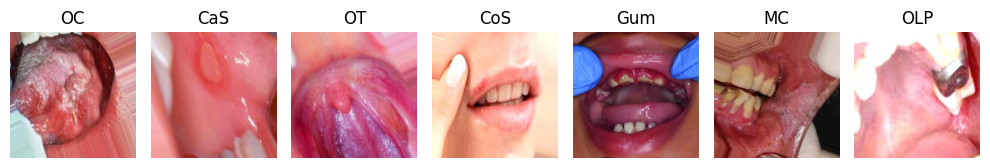

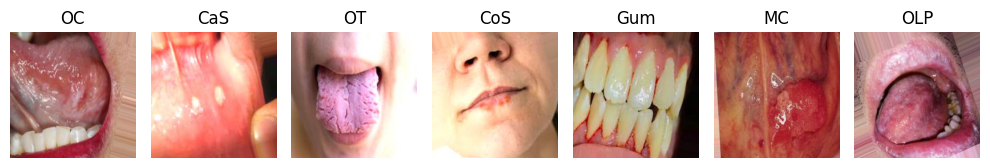

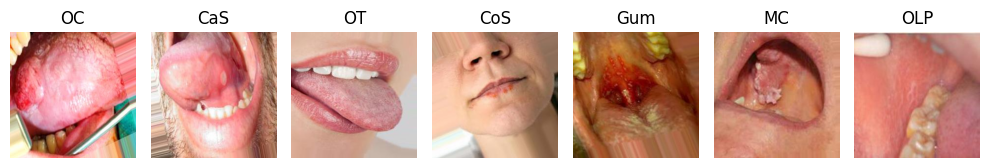

In [46]:

plot_1_per_disease_in_folder(folders[0] )

plot_1_per_disease_in_folder(folders[1] )

plot_1_per_disease_in_folder(folders[2] )


In [ ]:

def load_train_data_and_preprocess_it(train_data, target_size, batch_size):
    train_gen = ImageDataGenerator(
        rescale =  1/255.0,
        rotation_range = 20,
        width_shift_range = 0.2,
        height_shift_range = 0.2,
        shear_range = 0.2,
        zoom_range = 0.2,
        horizontal_flip = True,
        fill_mode = 'nearest',
    )

    train = train_gen.flow_from_directory(
        train_data,
        target_size = target_size,
        batch_size = batch_size,
        class_mode = 'categorical'
    )

    return train

def load_validation_data_and_preprocess_it(validation_data, target_size, batch_size):
    validation_gen = ImageDataGenerator(
        rescale =  1/255.0,
    )

    validation = validation_gen.flow_from_directory(
        validation_data,
        target_size = target_size,
        batch_size = batch_size,
        class_mode = 'categorical',
        shuffle = False
    )

    return validation


In [48]:
train = load_train_data_and_preprocess_it(
                train_path,
                target_size=(150, 150),
                batch_size=32
                )

validation = load_validation_data_and_preprocess_it(
                validation_path,
                target_size=(150, 150),
                batch_size=32
                )

Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.


In [49]:
imgs, labels = next(train)
print(imgs.shape)
print(labels.shape)

(32, 150, 150, 3)
(32, 7)


In [50]:
print(train.class_indices)
print(validation.class_indices)

{'CaS': 0, 'CoS': 1, 'Gum': 2, 'MC': 3, 'OC': 4, 'OLP': 5, 'OT': 6}
{'CaS': 0, 'CoS': 1, 'Gum': 2, 'MC': 3, 'OC': 4, 'OLP': 5, 'OT': 6}


In [ ]:

bad_images = []

base_path = '/kaggle/input/teethdataset/Teeth_Dataset/Training'

for root, dirs, files in os.walk(base_path):
    for file in files:
        if file.lower().endswith(('jpg', 'jpeg', 'png')):
            try:
                img = Image.open(os.path.join(root, file))
                img.verify()  # Will raise an exception if the image is corrupted
            except:
                bad_images.append(os.path.join(root, file))

print("Bad images:", bad_images)


Bad images: []


# Modeling VGG16

## Feature Extraction

In [52]:

input_shape = (150, 150, 3)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

base_model.trainable = False

# Add custom layers on top
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(7, activation='softmax')(x)

# Create final model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6
)

In [53]:
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,913,095 (72.15 MB)

 Trainable params: 4,198,407 (16.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

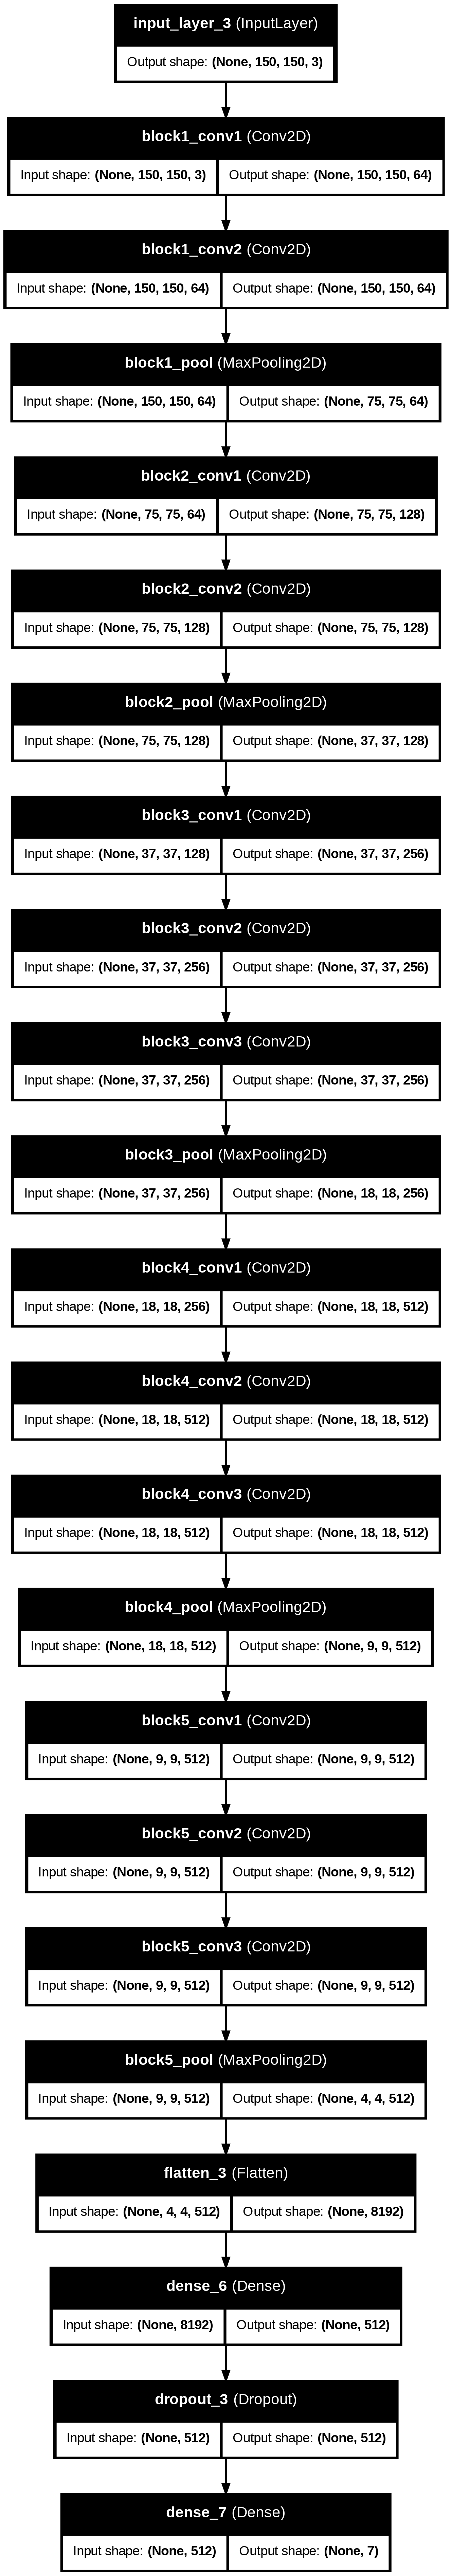

In [81]:
plot_model(
    model,
    to_file='VGG16_Feature Extraction.png',    
    show_shapes=True,    
    show_layer_names=True
)

In [55]:
history = model.fit(
    train,
    epochs=50,
    validation_data=validation,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 30s 277ms/step - accuracy: 0.2525 - loss: 1.9534 - val_accuracy: 0.5807 - val_loss: 1.2610 - learning_rate: 1.0000e-04
Epoch 2/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 24s 247ms/step - accuracy: 0.4724 - loss: 1.4094 - val_accuracy: 0.6333 - val_loss: 1.0920 - learning_rate: 1.0000e-04
Epoch 3/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 24s 249ms/step - accuracy: 0.5213 - loss: 1.3101 - val_accuracy: 0.6965 - val_loss: 0.9456 - learning_rate: 1.0000e-04
Epoch 4/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 25s 252ms/step - accuracy: 0.5682 - loss: 1.1754 - val_accuracy: 0.6868 - val_loss: 0.9077 - learning_rate: 1.0000e-04
Epoch 5/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 24s 243ms/step - accuracy: 0.5902 - loss: 1.1303 - val_accuracy: 0.7091 - val_loss: 0.8505 - learning_rate: 1.0000e-04
Epoch 6/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 24s 250ms/step - accuracy: 0.6017 - loss: 1.0823 - val_accuracy: 0.7549 - val_loss: 0.7672 - learning_rate: 1.0000e-04
Epoch 7/50
97/97 ━━━━━━━━━━━━━━━━━━━━ 24s 250ms/step - acc

<Axes: >

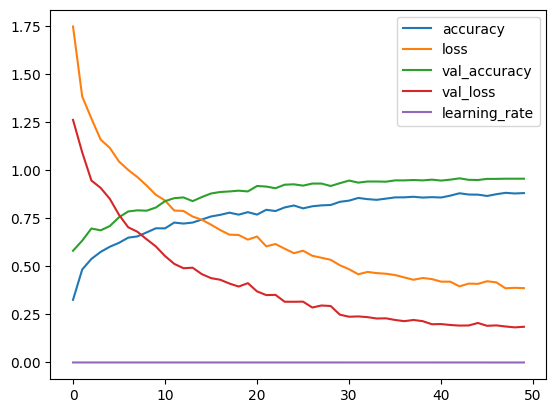

In [56]:
model_history = history.history
loss_acc_df = pd.DataFrame(model_history)
loss_acc_df.plot()

In [57]:
acc = model_history['accuracy']
val_acc = model_history['val_accuracy']
loss = model_history['loss']
val_loss = model_history['val_loss']

epochs = model.history.epoch

def plot_acc(acc, val_acc, epochs):
  plt.plot(epochs, acc, label='Training Accuracy')
  plt.plot(epochs, val_acc, label='Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc=0)
  plt.show()


def plot_loss(loss, val_loss, epochs):
  plt.plot(epochs, loss, label='Training Loss')
  plt.plot(epochs, val_loss, label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(loc=0)
  plt.show()


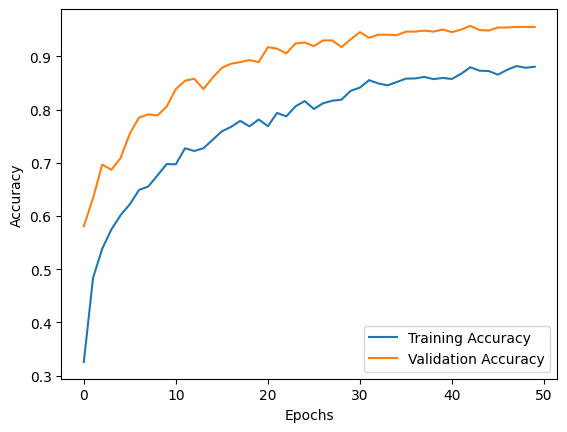

In [58]:
plot_acc(acc, val_acc, epochs)

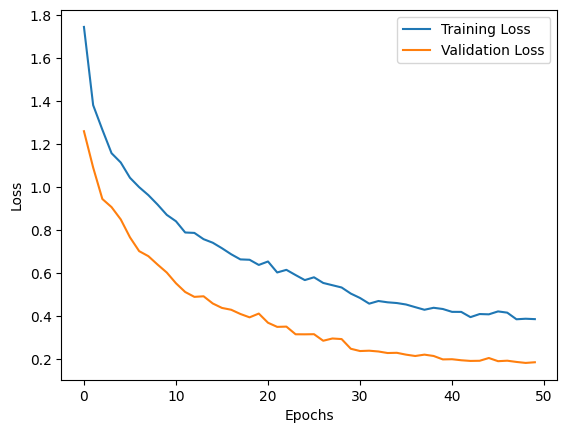

In [59]:
plot_loss(loss, val_loss, epochs)

In [60]:
test = load_validation_data_and_preprocess_it(
                test_path,
                target_size=(150, 150),
                batch_size=32
        )

Found 1028 images belonging to 7 classes.


In [61]:
test_loss, test_accuracy = model.evaluate(test)

33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - accuracy: 0.9641 - loss: 0.1515


In [62]:
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss: 0.19197095930576324
Test Accuracy: 0.9523346424102783


In [88]:
predictions = model.predict(test)


y_pred = np.argmax(predictions, axis=1)
y_true = test.classes


class_labels = list(test.class_indices.keys())


report = classification_report(y_true, y_pred, target_names=class_labels)
print(report)

33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step
              precision    recall  f1-score   support

         CaS       0.96      0.96      0.96       160
         CoS       0.99      0.99      0.99       149
         Gum       0.96      0.97      0.96       120
          MC       0.92      0.95      0.93       180
          OC       0.93      0.94      0.93       108
         OLP       0.95      0.91      0.93       180
          OT       0.97      0.96      0.97       131

    accuracy                           0.95      1028
   macro avg       0.95      0.95      0.95      1028
weighted avg       0.95      0.95      0.95      1028



<Figure size 800x600 with 0 Axes>

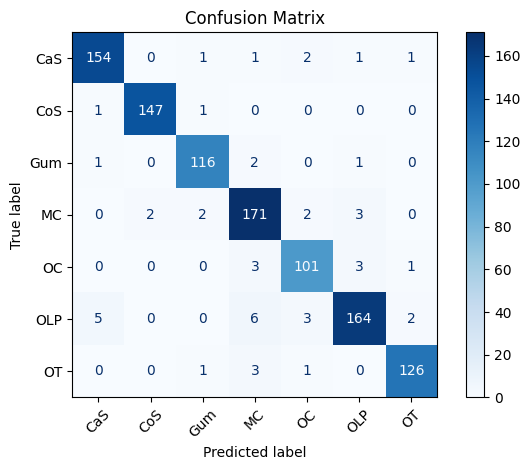

In [64]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()

In [65]:
model.save('VGG16_Feature Extraction.keras')

## Fine-Tuning

In [66]:
input_shape = (150, 150, 3)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

base_model.trainable = True

# Add custom layers on top
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(7, activation='softmax')(x)

# Create final model
fine_tuned_model = Model(inputs=base_model.input, outputs=output_layer)



In [67]:
print(len(base_model.layers))


19


In [68]:
for layer in base_model.layers[:15]:
    layer.trainable = False

In [69]:
# Compile the model
fine_tuned_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
) # It's commot to use a smaller learning rate for 'ConvNet' weights that are being fine-tuned


# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6
)

In [80]:
fine_tuned_model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,468,759 (158.19 MB)

 Trainable params: 11,277,831 (43.02 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

 Optimizer params: 22,555,664 (86.04 MB)

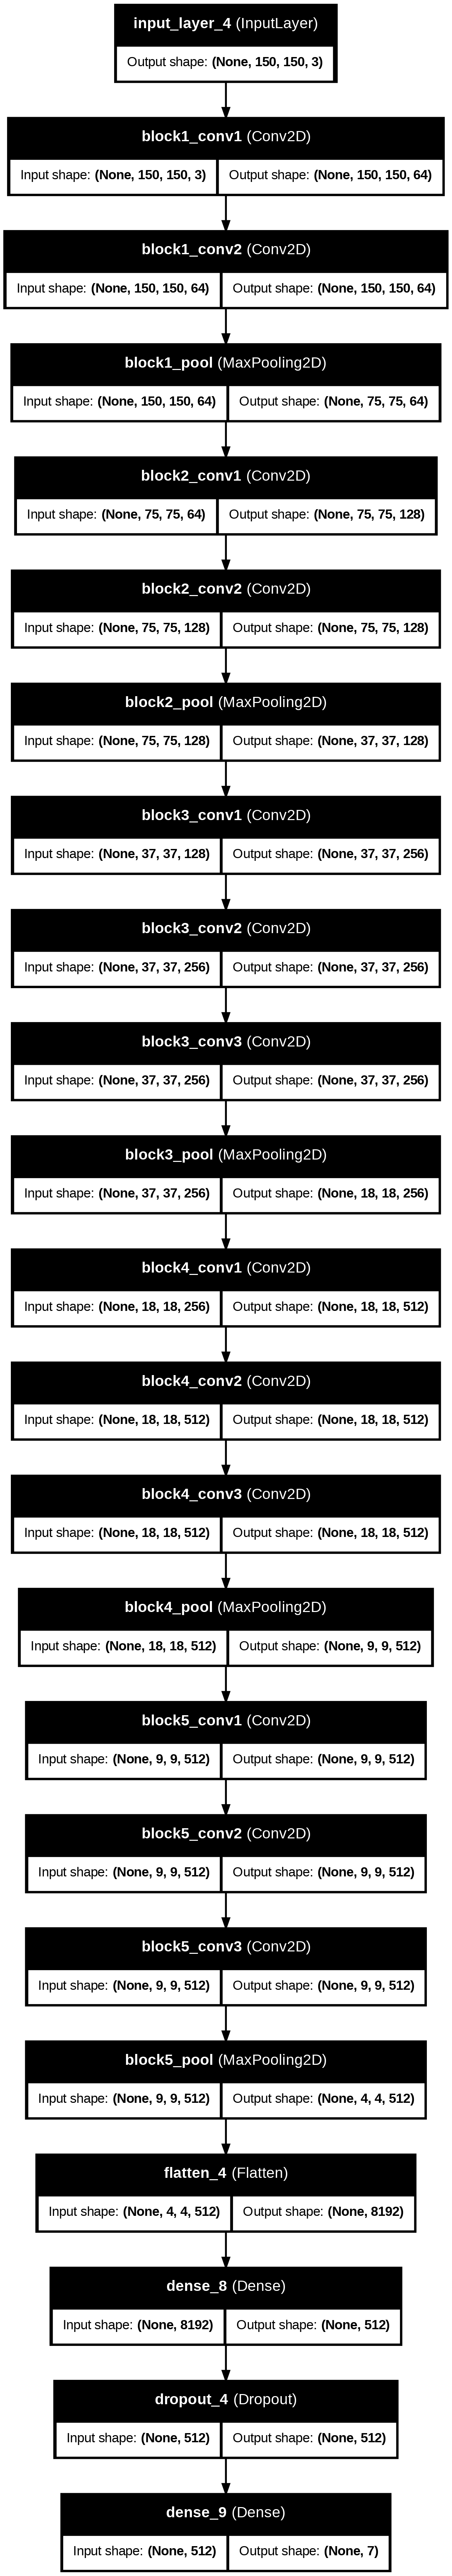

In [83]:
plot_model(
    fine_tuned_model,
    to_file='VGG16fine_tuned.png',    
    show_shapes=True,    
    show_layer_names=True
)

In [70]:
fine_tuned_history = fine_tuned_model.fit(
    train,
    epochs=35,
    validation_data=validation,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/35
97/97 ━━━━━━━━━━━━━━━━━━━━ 31s 280ms/step - accuracy: 0.1843 - loss: 2.0709 - val_accuracy: 0.5029 - val_loss: 1.5594 - learning_rate: 1.0000e-05
Epoch 2/35
97/97 ━━━━━━━━━━━━━━━━━━━━ 25s 257ms/step - accuracy: 0.3518 - loss: 1.6816 - val_accuracy: 0.5885 - val_loss: 1.2298 - learning_rate: 1.0000e-05
Epoch 3/35
97/97 ━━━━━━━━━━━━━━━━━━━━ 25s 259ms/step - accuracy: 0.4774 - loss: 1.4106 - val_accuracy: 0.6401 - val_loss: 1.0374 - learning_rate: 1.0000e-05
Epoch 4/35
97/97 ━━━━━━━━━━━━━━━━━━━━ 24s 250ms/step - accuracy: 0.5198 - loss: 1.2395 - val_accuracy: 0.6916 - val_loss: 0.9148 - learning_rate: 1.0000e-05
Epoch 5/35
97/97 ━━━━━━━━━━━━━━━━━━━━ 25s 258ms/step - accuracy: 0.6154 - loss: 1.0942 - val_accuracy: 0.7617 - val_loss: 0.7586 - learning_rate: 1.0000e-05
Epoch 6/35
97/97 ━━━━━━━━━━━━━━━━━━━━ 25s 253ms/step - accuracy: 0.6489 - loss: 0.9963 - val_accuracy: 0.7899 - val_loss: 0.6694 - learning_rate: 1.0000e-05
Epoch 7/35
97/97 ━━━━━━━━━━━━━━━━━━━━ 25s 258ms/step - acc

<Axes: >

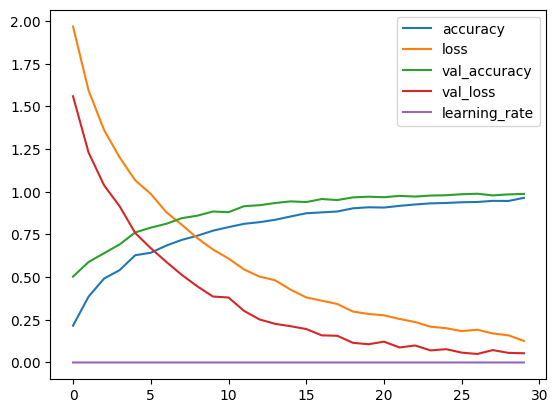

In [71]:
fine_tuned_model_history = fine_tuned_history.history
fine_tuned_loss_acc_df = pd.DataFrame(fine_tuned_model_history)
fine_tuned_loss_acc_df.plot()

In [72]:
fine_tuned_acc = fine_tuned_model_history['accuracy']
fine_tuned_val_acc = fine_tuned_model_history['val_accuracy']
fine_tuned_loss = fine_tuned_model_history['loss']
fine_tuned_val_loss = fine_tuned_model_history['val_loss']

fine_tuned_epochs = fine_tuned_model.history.epoch

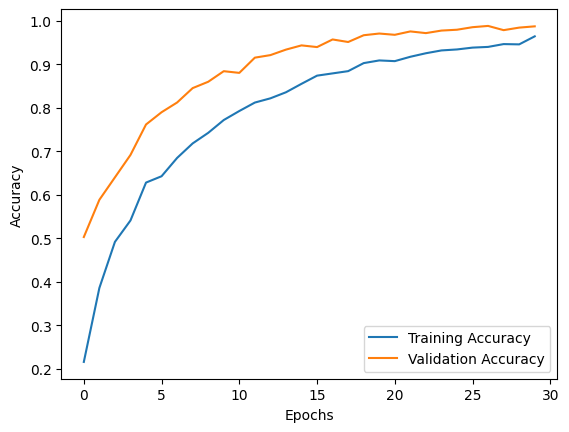

In [73]:
plot_acc(fine_tuned_acc, fine_tuned_val_acc, fine_tuned_epochs)

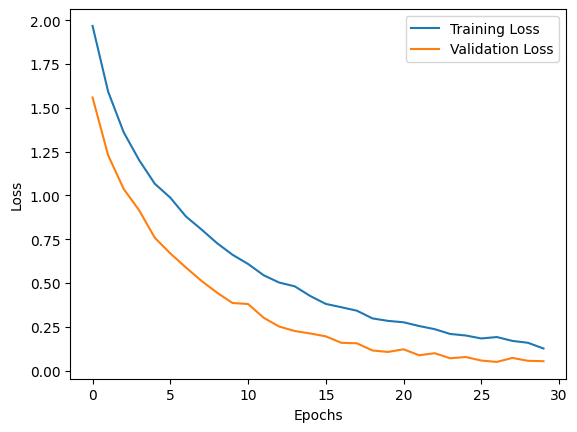

In [74]:
plot_loss(fine_tuned_loss, fine_tuned_val_loss, fine_tuned_epochs)

In [75]:
fine_tuned_test_loss, fine_tuned_test_accuracy = fine_tuned_model.evaluate(test)

33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - accuracy: 0.9886 - loss: 0.0446


In [76]:
print(f"Test Loss: {fine_tuned_test_loss}")
print(f"Test Accuracy: {fine_tuned_test_accuracy}")

Test Loss: 0.04532342776656151
Test Accuracy: 0.9883268475532532


In [87]:
fine_tuned_predictions = fine_tuned_model.predict(test)


fine_tuned_y_pred = np.argmax(fine_tuned_predictions, axis=1)
fine_tuned_y_true = test.classes


class_labels = list(test.class_indices.keys())


fine_tuned_report = classification_report(fine_tuned_y_true, fine_tuned_y_pred, target_names=class_labels)
print(fine_tuned_report)

33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step
              precision    recall  f1-score   support

         CaS       1.00      0.98      0.99       160
         CoS       1.00      1.00      1.00       149
         Gum       1.00      1.00      1.00       120
          MC       0.99      0.99      0.99       180
          OC       0.95      0.96      0.96       108
         OLP       0.98      0.99      0.99       180
          OT       0.99      0.98      0.99       131

    accuracy                           0.99      1028
   macro avg       0.99      0.99      0.99      1028
weighted avg       0.99      0.99      0.99      1028



<Figure size 800x600 with 0 Axes>

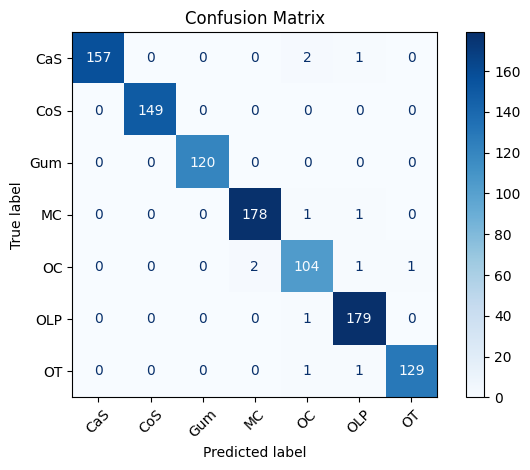

In [78]:
fine_tuned_cm = confusion_matrix(fine_tuned_y_true, fine_tuned_y_pred)

plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=fine_tuned_cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()

In [79]:
fine_tuned_model.save('VGG16fine_tuned.keras')

# The Best Model is `VGG16fine_tuned` With 'F1_score = 99%'

## Save Details About The Best Model

In [84]:
#Save the training history
with open('VGG16_finetuned_History.pkl', 'wb') as f:
    pickle.dump(fine_tuned_history.history, f)